In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#!pip install opencv-contrib-python
#!pip install pytesseract
#!pip install tesseract-ocr

In [3]:
import cv2
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import pytesseract
import skimage.color
import skimage.io
import skimage.measure
import skimage.segmentation
import skimage.transform
import skimage.filters 
import matplotlib.pyplot as plt

In [4]:
# !pdftoppm example.pdf example -png

In [5]:
pytesseract.pytesseract.tesseract_cmd = r"tesseract"

In [6]:
mask = skimage.io.imread("./example-1-mask.png", as_gray=True)

mask = ~skimage.img_as_bool(mask)

mask = skimage.measure.label(mask)

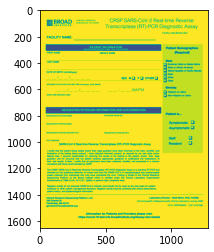

In [7]:
reference = skimage.io.imread("./example-1.png", as_gray=True)
reference = skimage.transform.resize(reference, mask.shape)
reference = skimage.img_as_ubyte(reference)
plt.imshow(reference)

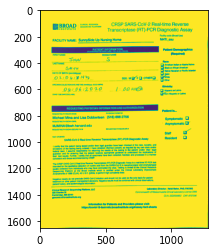

In [8]:
image = skimage.io.imread("./sample-1.png", as_gray=True)
#image = skimage.io.imread("./sample-2.png", as_gray=True)
#image = skimage.io.imread("./sample-3.png", as_gray=True)
#image = skimage.io.imread("./sample-4.png", as_gray=True)
image = skimage.transform.resize(image, mask.shape)
image = skimage.img_as_ubyte(image)
plt.imshow(image)

## Image registration

In [9]:
# TODO: replace OpenCV with scikit-image

model = cv2.AKAZE_create()

reference_keypoints, reference_descriptors = model.detectAndCompute(reference, None)
image_keypoints, image_descriptors = model.detectAndCompute(image, None)

matcher = cv2.BFMatcher()

matches = []

for m, n in matcher.knnMatch(reference_descriptors, image_descriptors, k=2):
    if m.distance < 0.75 * n.distance:
        matches.append([m])

matches_image = cv2.drawMatchesKnn(
    reference, 
    reference_keypoints, 
    image,
    image_keypoints,
    matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

reference_matched_keypoints, image_matched_keypoints = [], []

for index, match in enumerate(matches):
    reference_matched_keypoints += [reference_keypoints[match[0].queryIdx].pt]
    
    image_matched_keypoints += [image_keypoints[match[0].trainIdx].pt]

reference_matched_keypoints = numpy.float32(reference_matched_keypoints)
image_matched_keypoints = numpy.float32(image_matched_keypoints)

homography, status = cv2.findHomography(
    image_matched_keypoints, 
    reference_matched_keypoints, 
    cv2.RANSAC,
    5.0
)

registered = cv2.warpPerspective(image, homography, (mask.shape[1], mask.shape[0]))

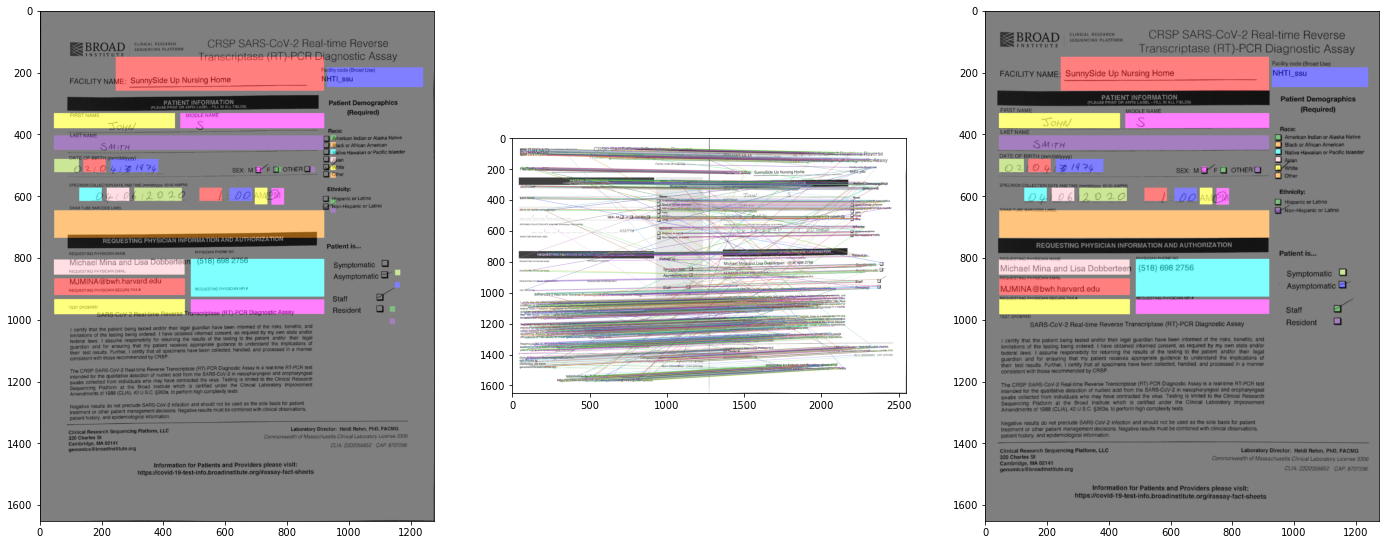

In [10]:
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(skimage.color.label2rgb(mask, image, alpha=0.5, bg_label=0))
axes[1].imshow(matches_image)
axes[2].imshow(skimage.color.label2rgb(mask, registered, alpha=0.5, bg_label=0))

# Binarization and Masking

In [11]:
reference_thresh = skimage.filters.threshold_otsu(reference)
reference_binary = skimage.img_as_ubyte(reference > reference_thresh)

registered_thresh = skimage.filters.threshold_otsu(registered)
registered_binary = skimage.img_as_ubyte(registered > registered_thresh)

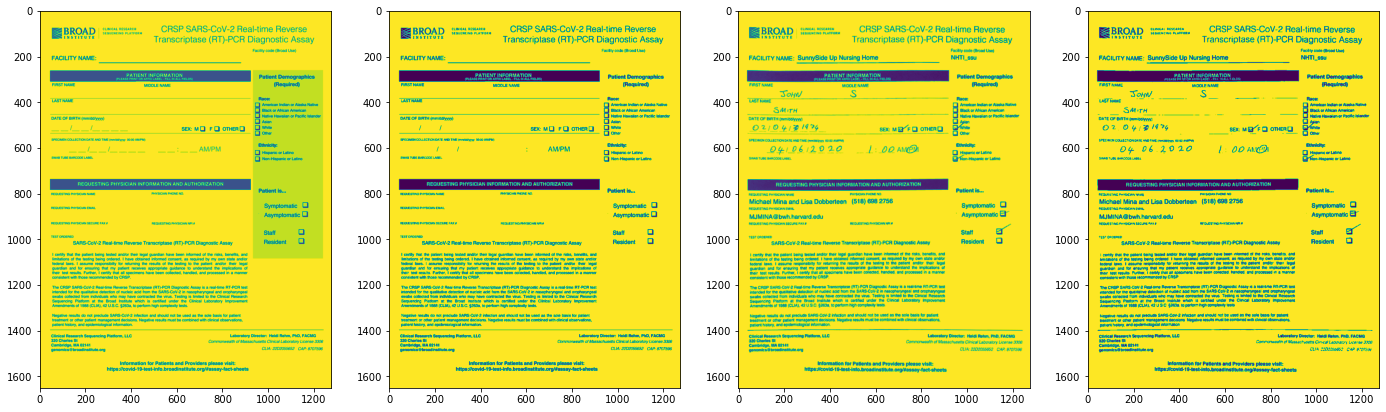

In [12]:
figure, axes = matplotlib.pyplot.subplots(ncols=4, figsize=(24, 24))

axes[0].imshow(reference)
axes[1].imshow(reference_binary)
axes[2].imshow(registered)
axes[3].imshow(registered_binary)

## Image masking

In [13]:
registered_masked = numpy.copy(mask)
registered_masked[mask > 0] = registered[mask > 0]

registered_binary_masked = numpy.copy(mask)
registered_binary_masked[mask > 0] = registered_binary[mask > 0]

reference_masked = numpy.copy(mask)
reference_masked[mask > 0] = reference[mask > 0]

reference_binary_masked = numpy.copy(mask)
reference_binary_masked[mask > 0] = reference_binary[mask > 0]

delta_masked = numpy.copy(mask)
delta_masked[mask > 0] = 255 - (reference_binary[mask > 0] - registered_binary[mask > 0])

delta_masked = skimage.img_as_ubyte(delta_masked)
reference_binary_masked = skimage.img_as_ubyte(reference_binary_masked)
reference_masked = skimage.img_as_ubyte(reference_masked)
registered_masked = skimage.img_as_ubyte(registered_masked)
registered_binary_masked = skimage.img_as_ubyte(registered_binary_masked)

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


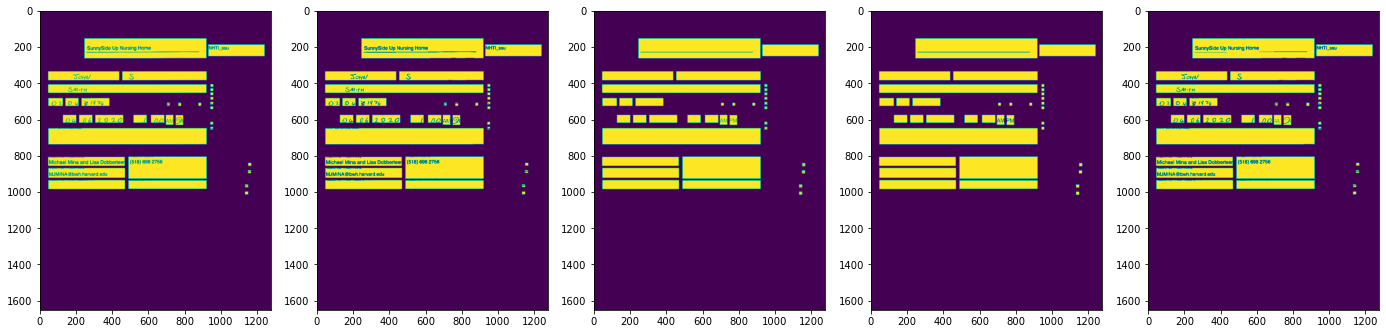

In [14]:
figure, axes = matplotlib.pyplot.subplots(ncols=5, figsize=(24, 24))

axes[0].imshow(registered_masked)
axes[1].imshow(registered_binary_masked)
axes[2].imshow(reference_masked)
axes[3].imshow(reference_binary_masked)
axes[4].imshow(delta_masked)

## Optical character recognition (OCR)

In [15]:
# the key of the 36 regions specified by the mask. Order is important
keys = [
    "facility_name",
    "facility_code",
    "first_name",
    "middle_name",
    "race_american_indian_or_alaska_native",
    "last_name",
    "race_black_or_african_american",
    "race_native_hawaiian_or_pacific_islander",
    "race_asian",
    "date_of_birth_month",
    "date_of_birth_day",
    "date_of_birth_year",
    "race_white",
    "sex_male",
    "sex_female",
    "sex_other",
    "race_other",
    "speciman_collection_date_month",
    "speciman_collection_date_day",
    "speciman_collection_date_year",
    "speciman_collection_date_hour",
    "speciman_collection_date_minute",
    "speciman_collection_date_am",
    "speciman_collection_date_pm",
    "ethnicity_hispanic_or_latino",
    "ethnicity_nonhispanic_or_latino",
    "swab_tube_barcode_label",
    "physician_phone_number",
    "requesting_physician_name",
    "patient_is_symptomatic",
    "requesting_physician_email",
    "patient_is_asymptomatic",
    "requesting_physician_secure_fax",
    "requesting_physician_npi",
    "patient_is_staff",
    "patient_is_resident"
]


numeric_fields = [  
    "date_of_birth_month",
    "date_of_birth_day",
    "date_of_birth_year",
    "speciman_collection_date_month",
    "speciman_collection_date_day",
    "speciman_collection_date_year",
    "speciman_collection_date_hour",
    "speciman_collection_date_minute",
    "physician_phone_number",
    "requesting_physician_secure_fax"]

alphanumeric_fields = [
    "facility_name",
    "facility_code",
    "first_name",
    "middle_name",
    "last_name",
    "swab_tube_barcode_label",
    "requesting_physician_name",
    "requesting_physician_email",
    "requesting_physician_npi"]

sex_one_hot = ["sex_male", "sex_female", "sex_other"]
race_one_hot = [
    "race_american_indian_or_alaska_native",
    "race_black_or_african_american",
    "race_native_hawaiian_or_pacific_islander",
    "race_asian",
    "race_white",
    "race_other"]
ethnicity_one_hot = ["ethnicity_hispanic_or_latino", "ethnicity_nonhispanic_or_latino"]
symptomatic_one_hot = [ "patient_is_symptomatic", "patient_is_asymptomatic"]
patient_one_hot = ["patient_is_staff", "patient_is_resident"]
am_pm_one_hot = ["speciman_collection_date_am", "speciman_collection_date_pm"] 

one_hot_list_of_list = [
    sex_one_hot, 
    race_one_hot, 
    ethnicity_one_hot, 
    symptomatic_one_hot, 
    patient_one_hot, 
    am_pm_one_hot]

### Make association between keys and regions

In [16]:
regions_diff_dict=dict(zip(keys, skimage.measure.regionprops(mask, delta_masked)))

## Read the alphanumeric fields

{'facility_name': 'SunnySide Up Nursing Home', 'facility_code': 'NHTI_ssu', 'first_name': 'Douw', 'middle_name': 'S ee', 'last_name': 'Smurxe', 'swab_tube_barcode_label': 'area', 'requesting_physician_name': 'Michael Mina and Lisa Dobberteer', 'requesting_physician_email': 'MJMINA@bwh.harvard.edu', 'requesting_physician_npi': 're'}


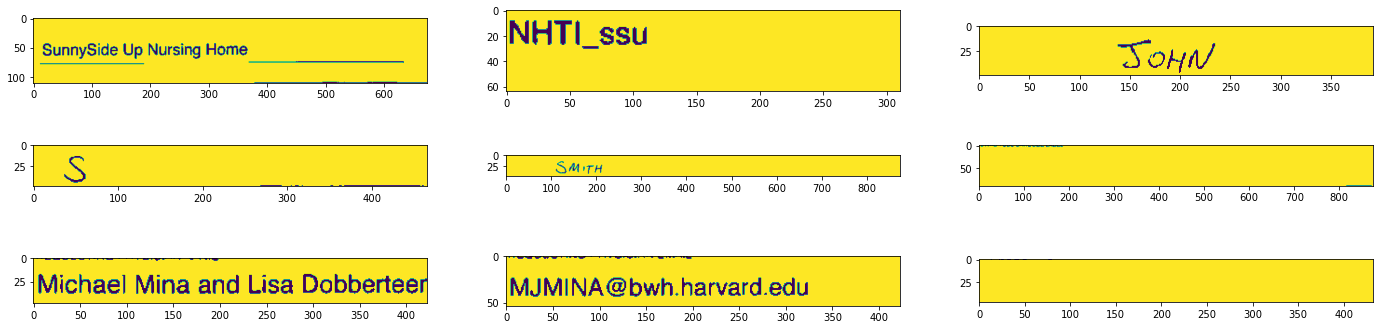

In [17]:
figure, axes = matplotlib.pyplot.subplots(nrows=3, ncols=3, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[alphanumeric_fields[0]].intensity_image)
axes[0,1].imshow(regions_diff_dict[alphanumeric_fields[1]].intensity_image)
axes[0,2].imshow(regions_diff_dict[alphanumeric_fields[2]].intensity_image)
axes[1,0].imshow(regions_diff_dict[alphanumeric_fields[3]].intensity_image)
axes[1,1].imshow(regions_diff_dict[alphanumeric_fields[4]].intensity_image)
axes[1,2].imshow(regions_diff_dict[alphanumeric_fields[5]].intensity_image)
axes[2,0].imshow(regions_diff_dict[alphanumeric_fields[6]].intensity_image)
axes[2,1].imshow(regions_diff_dict[alphanumeric_fields[7]].intensity_image)
axes[2,2].imshow(regions_diff_dict[alphanumeric_fields[8]].intensity_image)

def read_alphanumeric_fields(keys, regions_dict):
    config= '--psm 7 --oem 3'
    inferred = []
    for k in keys:
        inferred += [pytesseract.image_to_string(regions_dict[k].intensity_image, config=config)]
    return dict(zip(keys,inferred))

info_alphanumeric = read_alphanumeric_fields(keys=alphanumeric_fields, regions_dict=regions_diff_dict)
print(info_alphanumeric)

## Read the numeric fields

{'date_of_birth_month': 'O22', 'date_of_birth_day': 'O4', 'date_of_birth_year': '143', 'speciman_collection_date_month': 'O4', 'speciman_collection_date_day': 'O', 'speciman_collection_date_year': '2020', 'speciman_collection_date_hour': '4', 'speciman_collection_date_minute': ')O', 'physician_phone_number': '', 'requesting_physician_secure_fax': ''}


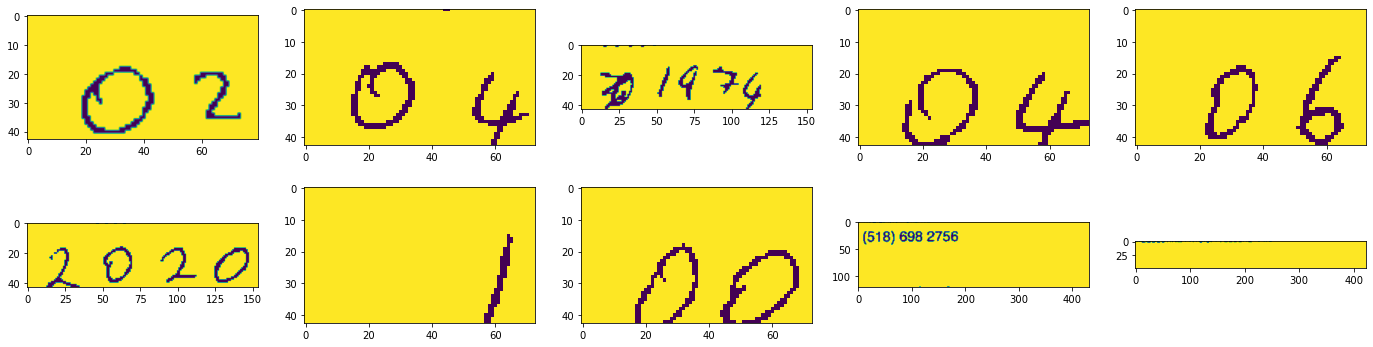

In [18]:
figure, axes = matplotlib.pyplot.subplots(nrows=2, ncols=5, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[numeric_fields[0]].intensity_image)
axes[0,1].imshow(regions_diff_dict[numeric_fields[1]].intensity_image)
axes[0,2].imshow(regions_diff_dict[numeric_fields[2]].intensity_image)
axes[0,3].imshow(regions_diff_dict[numeric_fields[3]].intensity_image)
axes[0,4].imshow(regions_diff_dict[numeric_fields[4]].intensity_image)
axes[1,0].imshow(regions_diff_dict[numeric_fields[5]].intensity_image)
axes[1,1].imshow(regions_diff_dict[numeric_fields[6]].intensity_image)
axes[1,2].imshow(regions_diff_dict[numeric_fields[7]].intensity_image)
axes[1,3].imshow(regions_diff_dict[numeric_fields[8]].intensity_image)
axes[1,4].imshow(regions_diff_dict[numeric_fields[9]].intensity_image)

def read_numeric_fields(keys, regions_dict):
    #config= "--psm 7 --oem 3"
    #config= '--psm 13 --oem 3 -c tessedit_char_whitelist=" "(0123456789O)'
    config= '--psm 8 --oem 3 -c tessedit_char_whitelist=" "(0123456789O)'
    inferred = []
    for k in keys:
        inferred += [pytesseract.image_to_string(regions_dict[k].intensity_image, config=config)]
    return dict(zip(keys,inferred))

info_numeric = read_numeric_fields(numeric_fields, regions_diff_dict)
print(info_numeric)

# Read the hot encoding manually

{'sex_male': 'Yes', 'sex_female': 'None', 'sex_other': 'None', 'race_american_indian_or_alaska_native': 'None', 'race_black_or_african_american': 'None', 'race_native_hawaiian_or_pacific_islander': 'None', 'race_asian': 'None', 'race_white': 'Yes', 'race_other': 'None', 'ethnicity_hispanic_or_latino': 'None', 'ethnicity_nonhispanic_or_latino': 'Yes', 'patient_is_symptomatic': 'None', 'patient_is_asymptomatic': 'Yes', 'patient_is_staff': 'Yes', 'patient_is_resident': 'None', 'speciman_collection_date_am': 'None', 'speciman_collection_date_pm': 'Yes'}


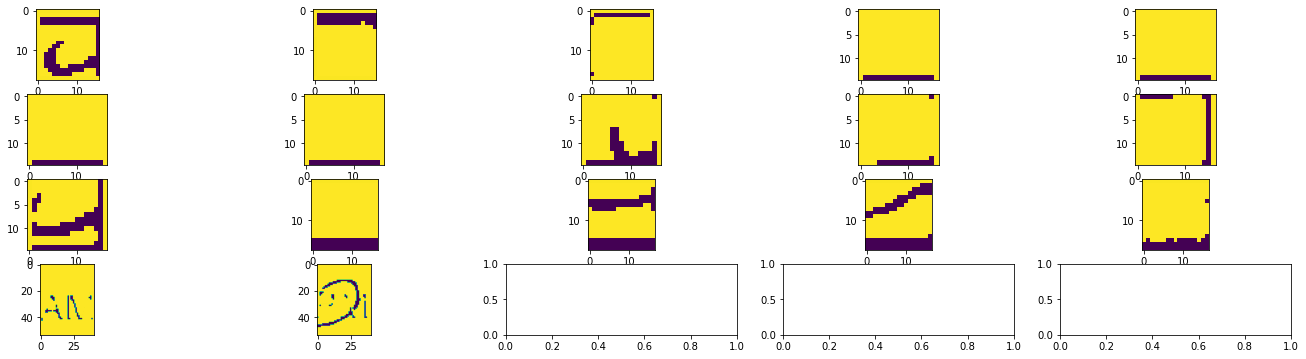

In [19]:
one_hot_flattened = [item for sublist in one_hot_list_of_list for item in sublist]

figure, axes = matplotlib.pyplot.subplots(nrows=4, ncols=5, figsize=(24, 6))

axes[0,0].imshow(regions_diff_dict[one_hot_flattened[0]].intensity_image)
axes[0,1].imshow(regions_diff_dict[one_hot_flattened[1]].intensity_image)
axes[0,2].imshow(regions_diff_dict[one_hot_flattened[2]].intensity_image)
axes[0,3].imshow(regions_diff_dict[one_hot_flattened[3]].intensity_image)
axes[0,4].imshow(regions_diff_dict[one_hot_flattened[4]].intensity_image)
axes[1,0].imshow(regions_diff_dict[one_hot_flattened[5]].intensity_image)
axes[1,1].imshow(regions_diff_dict[one_hot_flattened[6]].intensity_image)
axes[1,2].imshow(regions_diff_dict[one_hot_flattened[7]].intensity_image)
axes[1,3].imshow(regions_diff_dict[one_hot_flattened[8]].intensity_image)
axes[1,4].imshow(regions_diff_dict[one_hot_flattened[9]].intensity_image)
axes[2,0].imshow(regions_diff_dict[one_hot_flattened[10]].intensity_image)
axes[2,1].imshow(regions_diff_dict[one_hot_flattened[11]].intensity_image)
axes[2,2].imshow(regions_diff_dict[one_hot_flattened[12]].intensity_image)
axes[2,3].imshow(regions_diff_dict[one_hot_flattened[13]].intensity_image)
axes[2,4].imshow(regions_diff_dict[one_hot_flattened[14]].intensity_image)
axes[3,0].imshow(regions_diff_dict[one_hot_flattened[15]].intensity_image)
axes[3,1].imshow(regions_diff_dict[one_hot_flattened[16]].intensity_image)

def resolve_one_hot(keys, regions_dict):
    inferred = ["None"]*len(keys)
    values_list = []
    for k in keys:
        values_list += [numpy.sum(regions_dict[k].intensity_image)]
    values_np = numpy.asarray(values_list)
    index = numpy.argmin(values_np)
    inferred[index] = "Yes" 
    return dict(zip(keys,inferred))

info_one_hot = {}
for one_hot in one_hot_list_of_list:
    tmp = resolve_one_hot(one_hot, regions_diff_dict)
    info_one_hot.update(tmp)
    
print(info_one_hot)

# Conclusion 

{'sex_male': 'Yes', 'sex_female': 'None', 'sex_other': 'None', 'race_american_indian_or_alaska_native': 'None', 'race_black_or_african_american': 'None', 'race_native_hawaiian_or_pacific_islander': 'None', 'race_asian': 'None', 'race_white': 'Yes', 'race_other': 'None', 'ethnicity_hispanic_or_latino': 'None', 'ethnicity_nonhispanic_or_latino': 'Yes', 'patient_is_symptomatic': 'None', 'patient_is_asymptomatic': 'Yes', 'patient_is_staff': 'Yes', 'patient_is_resident': 'None', 'speciman_collection_date_am': 'None', 'speciman_collection_date_pm': 'Yes', 'date_of_birth_month': 'O22', 'date_of_birth_day': 'O4', 'date_of_birth_year': '143', 'speciman_collection_date_month': 'O4', 'speciman_collection_date_day': 'O', 'speciman_collection_date_year': '2020', 'speciman_collection_date_hour': '4', 'speciman_collection_date_minute': ')O', 'physician_phone_number': '', 'requesting_physician_secure_fax': ''}
{'date_of_birth_month': 'O22', 'date_of_birth_day': 'O4', 'date_of_birth_year': '143', 'spec

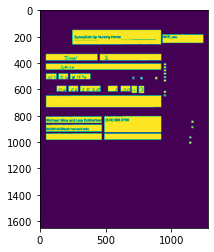

In [35]:
plt.imshow(delta_masked)

print(info_one_hot)
print(info_numeric)
print(info_alphanumeric)

In [ ]:
figure, axes = matplotlib.pyplot.subplots(ncols=10, figsize=(24, 24))

axes[0].imshow(regions_diff_dict[numeric_fields[0]].intensity_image)
axes[1].imshow(regions_diff_dict[numeric_fields[1]].intensity_image)
axes[2].imshow(regions_diff_dict[numeric_fields[2]].intensity_image)
axes[3].imshow(regions_diff_dict[numeric_fields[3]].intensity_image)
axes[4].imshow(regions_diff_dict[numeric_fields[4]].intensity_image)
axes[5].imshow(regions_diff_dict[numeric_fields[5]].intensity_image)
axes[6].imshow(regions_diff_dict[numeric_fields[6]].intensity_image)
axes[7].imshow(regions_diff_dict[numeric_fields[7]].intensity_image)
axes[8].imshow(regions_diff_dict[numeric_fields[8]].intensity_image)
axes[9].imshow(regions_diff_dict[numeric_fields[9]].intensity_image)

In [ ]:
# AM/PM example
figure, axes = matplotlib.pyplot.subplots(ncols=2, figsize=(24, 24))

axes[0].imshow(regions_diff_dict[am_pm_one_hot[0]].intensity_image)
axes[1].imshow(regions_diff_dict[am_pm_one_hot[1]].intensity_image)

for k in am_pm_one_hot:
    print(k,"-->",numpy.sum(regions_diff_dict[k].intensity_image))

In [ ]:
# AM/PM example
figure, axes = matplotlib.pyplot.subplots(ncols=2, figsize=(24, 24))

axes[0].imshow(regions_dict[am_pm_one_hot[0]].intensity_image)
axes[1].imshow(regions_dict[am_pm_one_hot[1]].intensity_image)

for k in am_pm_one_hot:
    print(k,"-->",numpy.mean(regions_dict[k].intensity_image))

In [ ]:
# sex example
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(regions_diff_dict[sex_one_hot[0]].intensity_image)
axes[1].imshow(regions_diff_dict[sex_one_hot[1]].intensity_image)
axes[2].imshow(regions_diff_dict[sex_one_hot[2]].intensity_image)

for k in sex_one_hot:
    print(k,"-->",numpy.mean(regions_diff_dict[k].intensity_image))

In [ ]:
# sex example
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(regions_dict[sex_one_hot[0]].intensity_image)
axes[1].imshow(regions_dict[sex_one_hot[1]].intensity_image)
axes[2].imshow(regions_dict[sex_one_hot[2]].intensity_image)

for k in sex_one_hot:
    print(k,"-->",numpy.mean(regions_dict[k].intensity_image))

In [ ]:
v_reg = []
for region, config, k in zip(skimage.measure.regionprops(mask, registered_masked), config_list, keys):
    v_reg += [pytesseract.image_to_string(region.intensity_image, lang='eng', config=config)]
    print(k,"<-->",v_reg[-1])

In [ ]:
v_reg_bin = []
for region in skimage.measure.regionprops(mask, registered_binary_masked):
    v_reg_bin += [pytesseract.image_to_string(region.intensity_image, lang='eng', config='--psm 7 --oem 3')]

In [ ]:
for a,b, in zip(v_reg,v_reg_bin):
    print(a,"<-->",b)

In [ ]:
for region, config, a in zip(skimage.measure.regionprops(mask, masked), config_list, k):   
    #print(region.intensity_image.shape)
    #print(type(region.intensity_image))
    
  
    v1 += [pytesseract.image_to_string(region.intensity_image, lang='eng', config='--psm 7 --oem 3')]
    v2 += [pytesseract.image_to_string(region.intensity_image, lang='eng', config=config)]
    print()
    print("---",n,"--",a)
    print("basic ---->",v1[-1])
    print("specific ->",v2[-1])
    if n==4:
        plt.imshow(region.intensity_image)
        assert 1==2
    n+=1 
data = dict(zip(k, v))



#tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz

config_list = [
    "--psm 6 --oem 3 -c tessedit_char_blacklist=0123456789",  #signle line of text facility_name
    "--psm 6 --oem 3 -c tessedit_char_blacklist=0123456789",  #signle line of text facility_code
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word first_name
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word middle_name
    "--psm 10 --oem 3 -c tessedit_char_whitelist=x/.\*-v", #check_mark race1
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word last_name
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race2"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race3"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race4"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field month
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field day 
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field year
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field hour
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field minute
    "--psm 10 --oem 3", #single character AM
    "--psm 10 --oem 3", #single character PM
    "--psm 10 --oem 3", #single character hispanic
    "--psm 10 --oem 3", #single character not_hispanic
    "--psm 7 --oem 3", #single line swab_barcode
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field phone
    "--psm 7 --oem 3 -c tessedit_char_blacklist=0123456789", #line of text physicia name
    "--psm 10 --oem 3", #single character symptomatic
    "--psm 7 --oem 3",  #signle line of text email
    "--psm 10 --oem 3", #single character asymptomatic
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field fax
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field npi
    "--psm 10 --oem 3", #single character staff
    "--psm 10 --oem 3", #single character resident
   ] 

for c, a in zip(config_list, k):
    print(a,"->",c)

In [ ]:
print(len(k))
print(len(config_list))

In [ ]:

 #'--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'

# config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

#config = r'--oem 1 --psm 7'

#%matplotlib inline
#%matplotlib notebook
#import matplotlib.pyplot as plt

In [ ]:
#plt.imshow(masked)

In [ ]:
v1, v2 = [], []
n=0
#print(config_list)
for region, config, a in zip(skimage.measure.regionprops(mask, masked), config_list, k):   
    #print(region.intensity_image.shape)
    #print(type(region.intensity_image))
    
  
    v1 += [pytesseract.image_to_string(region.intensity_image, lang='eng', config='--psm 7 --oem 3')]
    v2 += [pytesseract.image_to_string(region.intensity_image, lang='eng', config=config)]
    print()
    print("---",n,"--",a)
    print("basic ---->",v1[-1])
    print("specific ->",v2[-1])
    if n==4:
        plt.imshow(region.intensity_image)
        assert 1==2
    n+=1 
data = dict(zip(k, v))

In [ ]:
data

In [ ]:
for region, config, a in zip(skimage.measure.regionprops(mask, masked), config_list, k):   

In [ ]:
_ = plt.hist(registered.flatten())

In [ ]:
_ = plt.hist(registered_binary.flatten())

In [ ]:
_ = plt.hist(reference.flatten())

In [ ]:
_ = plt.hist(reference_binary.flatten())

In [ ]:
img_as_int

In [ ]:
delta = skimage.img_as_int(registered_binary)-skimage.img_as_int(reference_binary)
plt.imshow(delta)

In [ ]:
figure, axes = matplotlib.pyplot.subplots(ncols=2, figsize=(24, 24))

axes[0].imshow(registered-reference)
axes[1].imshow(registered_binary-reference_binary)

In [ ]:
reference

In [ ]:

reference_thresh = skimage.filters.threshold_otsu(reference)
reference_binary = skimage.img_as_ubyte(reference > reference_thresh)
plt.imshow(reference_binary)

In [ ]:
plt.imshow(registered)

In [ ]:
registered_thresh = skimage.filters.threshold_otsu(registered)
registered_binary = skimage.img_as_ubyte(registered > registered_thresh)
plt.imshow(registered_binary)

In [ ]:
plt.imshow(registered_binary)

In [ ]:
plt.imshow(registered-reference)

In [ ]:
plt.imshow(registered_binary-reference_binary)

In [ ]:
figure, axes = matplotlib.pyplot.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(skimage.color.label2rgb(mask, image, alpha=0.5, bg_label=0))
axes[1].imshow(matches_image)
axes[2].imshow(skimage.color.label2rgb(mask, registered, alpha=0.5, bg_label=0))

In [ ]:
figure = matplotlib.pyplot.figure(figsize=(12, 12))

binary_masked = numpy.copy(mask)
binary_masked[binary_masked > 0] = binary_registered[mask > 0]
binary_masked = skimage.img_as_ubyte(binary_masked)

skimage.io.imshow(binary_masked)

In [ ]:
registered_regions = skimage.measure.regionprops(mask, registered_binary_masked)
reference_regions = skimage.measure.regionprops(mask, reference_binary_masked)

In [ ]:
plt.imshow(registered_masked)

In [ ]:
figure, axes = matplotlib.pyplot.subplots(ncols=4, figsize=(12, 12))

axes[0].imshow(skimage.io.imshow(registered_masked))
axes[1].imshow(skimage.io.imshow(binary_registered_masked))
axes[2].imshow(skimage.io.imshow(reference_masked))
axes[3].imshow(skimage.io.imshow(binary_reference_masked))

### Difference of binarized image is informative

In [ ]:
delta = skimage.img_as_int(registered_binary)-skimage.img_as_int(reference_binary)
plt.imshow(delta)

In [ ]:
skimage.measure.regionprops(mask, masked)skimage.measure.regionprops(mask, masked)

In [ ]:
registered_regions = skimage.measure.regionprops(mask, registered_binary_masked)
reference_regions = skimage.measure.regionprops(mask, reference_binary_masked)

In [ ]:
config_list = [
    "--psm 6 --oem 3 -c tessedit_char_blacklist=0123456789",  #signle line of text facility_name
    "--psm 6 --oem 3 -c tessedit_char_blacklist=0123456789",  #signle line of text facility_code
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word first_name
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word middle_name
    "--psm 10 --oem 3 -c tessedit_char_whitelist=x/.\*-v", #check_mark race1
    "--psm 8 --oem 3 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",  #single word last_name
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race2"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race3"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=x/Oo.\*-_,", #check_mark race4"
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 10 --oem 3", #single character
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field month
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field day 
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field year
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field hour
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field minute
    "--psm 10 --oem 3", #single character AM
    "--psm 10 --oem 3", #single character PM
    "--psm 10 --oem 3", #single character hispanic
    "--psm 10 --oem 3", #single character not_hispanic
    "--psm 7 --oem 3", #single line swab_barcode
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field phone
    "--psm 7 --oem 3 -c tessedit_char_blacklist=0123456789", #line of text physicia name
    "--psm 10 --oem 3", #single character symptomatic
    "--psm 7 --oem 3",  #signle line of text email
    "--psm 10 --oem 3", #single character asymptomatic
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field fax
    "--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789", #numeric field npi
    "--psm 10 --oem 3", #single character staff
    "--psm 10 --oem 3", #single character resident
   ] 

In [ ]:
regions_dict=dict(zip(keys, skimage.measure.regionprops(mask, registered_masked)))